In [112]:
import  pandas as pd
import numpy as np

# データ読み込み

In [113]:
link_df = pd.read_csv("links_final.csv", index_col=0)
link_df.head()

,from,to,value,from_id,to_id
0,慶應義塾大学,研究,0.025952,3,198
1,慶應義塾大学,学部,0.022282,3,48
2,慶應義塾大学,月,0.020959,3,131
3,慶應義塾大学,学生,0.020782,3,60
4,慶應義塾大学,情報,0.019950,3,147


In [114]:
node_df = pd.read_csv('nodes_final.csv')
node_df.head(7)

,query,from_ut,from_ky,from_wa,from_ko,from_me,shortest_step,label_ut,label_ky,label_wa,label_ko,label_me,id,label
0,東京大学,0,2,2,2,4,0,True,False,False,False,False,0,0
1,京都大学,2,0,2,2,3,0,False,True,False,False,False,1,1
2,早稲田大学,2,2,0,2,2,0,False,False,True,False,False,2,2
3,慶應義塾大学,2,2,2,0,2,0,False,False,False,True,False,3,3
4,明治大学,4,3,2,2,0,0,False,False,False,False,True,4,4
5,卒業生,4,4,2,3,3,2,False,False,True,False,False,5,2
6,受験,5,5,3,5,5,3,False,False,True,False,False,6,2


# 座標

In [115]:
# 座標変換用の関数
import numpy
def xyz2r(p):
    r = np.sqrt((p ** 2).sum())
    theta = np.arccos(p[0] / r)
    phi = np.arccos(p[0] / np.sqrt((p[0:2] ** 2).sum()))
    return np.array([r, theta, phi])
def r2xyz(p):
    r = p[0]
    theta = p[1]
    phi = p[2]
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z])

In [116]:
tmp = np.array([0, 0])
non = [0, None, None, None]
ps = list(np.array([[-1,1,1], [-1,-1,-1], [1,1,-1], [1,-1,1], [-1,1,-1]])*3) # CHANGE:大学ノードの座標
univ_data = []
for univ_index in range(0,5):
    row = []
    row.extend(list(tmp))
    tmp = tmp + 1
    row.extend(non)
    row.extend(ps[univ_index])
    univ_data.append(row)

In [117]:
from numpy.random import *
import copy
r = np.array([3, 1.5, 0.75, 0.375, 0.1875]) # CHANGE:ノード間の距離r
data = {}
pos_df = pd.DataFrame(univ_data).rename(columns={0:'id', 1:'univ_index', 2:'shortest_step', 3:'r', 4:'theta', 5:'phi', 6:'x', 7:'y', 8:'z'})
for univ_index in range(0,5): # 大学のindex
    data[univ_index] = [[], [], [], [], [], [], [], [], []]
    univ_node_df = node_df[node_df.label == univ_index]
    unique_steps = set(univ_node_df['shortest_step'].unique())
    unique_steps.remove(0)
    if 99 in unique_steps:
        unique_steps.remove(99)
    for step in unique_steps: # step数
        univ_step_nodes_ids = univ_node_df[univ_node_df.shortest_step == step].id.values # nodeのid
        positions = [np.array([r[step-1], uniform(0, np.pi, 1)[0], uniform(0, np.pi, 1)[0]]) for _ in range(len(univ_step_nodes_ids))] # rtp_position
        if len(positions) >1:
            for c in range(50): 
                Fs = [0]* len(positions)
                for i in range(len(positions)):
                    F = np.array([0,0,0])
                    for j, position in enumerate(positions):
                        if i != j:
#                             F = F + (positions[i] - position  - (positions[i] - position) / (positions[i] - position).sum())
                            F = F + (positions[i] - position  - (positions[i] - position) / np.linalg.norm(positions[i] - position)) #CHANGE: 極座標のベクトルの長さ？？？
                            
                    Fs[i] = F / (len(positions) - 1)
                for i in range(len(positions)):
                    for j in range(len(Fs[i])):
                        while abs(Fs[i][j]) > np.pi:
                            if Fs[i][j] > 0:
                                Fs[i][j] = Fs[i][j] - np.pi
                            else:
                                Fs[i][j] = Fs[i][j] + np.pi
                    positions[i] = positions[i] + Fs[i] / np.pi
        l = len(univ_step_nodes_ids)
        xyz_positions = list(map(r2xyz, positions))
        data[univ_index][0].extend(univ_step_nodes_ids)
        data[univ_index][1].extend([univ_index] * l)
        data[univ_index][2].extend([step] * l)
        data[univ_index][3].extend(np.array(positions).T[0])
        data[univ_index][4].extend(np.array(positions).T[1])
        data[univ_index][5].extend(np.array(positions).T[2])
        data[univ_index][6].extend(np.array(xyz_positions).T[0])
        data[univ_index][7].extend(np.array(xyz_positions).T[1])
        data[univ_index][8].extend(np.array(xyz_positions).T[2])
    pos_df = pd.concat([pos_df, pd.DataFrame(data[univ_index]).T.rename(columns={0:'id', 1:'univ_index', 2:'shortest_step', 3:'r', 4:'theta', 5:'phi', 6:'x', 7:'y', 8:'z'})]).reset_index(drop=True)

In [118]:
pos_df.to_csv('relative_pos.csv', index=False)

In [119]:
# links = {}
real_pos = {}
for univ_index in range(0,5):
    univ_pos_df = pos_df[pos_df.univ_index == univ_index] # 大学の全てのnodeのdf
    real_pos[univ_index] = pos_df[pos_df.id == univ_index][['x', 'y', 'z']].values[0]
#     links[univ_index] = set(link_df[link_df.from_id == univ_index]['to_id'].values)
    max_n_step = int(max(univ_pos_df['shortest_step'].unique()))
    ids = {step:set(univ_pos_df[univ_pos_df.shortest_step == step].id.values) for step in range(0, max_n_step+1)}
    for step in range(1, max_n_step+1):
        step_ids = ids[step] # 現在のstepに属するnodeのid
        from_ids = ids[step-1] # 一つ前のstepに属するnodeのid
        exist_id = []
        for step_id in step_ids:
            for from_id in from_ids:
                to_ids = set(link_df[link_df.from_id == from_id].to_id.values) # 一つ前のstepのnodeのto_nodeを抽出
                if step_id in to_ids:
                    before_node_id = from_id
                    before_node_pos = real_pos[before_node_id]
                    node_pos = univ_pos_df[univ_pos_df.id == step_id][['x', 'y','z']].values[0]
                    real_pos[step_id] = before_node_pos + node_pos
                    exist_id.append(step_id)
                    break

In [120]:
real_pos_df = pd.DataFrame.from_dict(real_pos, orient='index').reset_index().rename(columns={'index':'id', 0:'x', 1:'y', 2:'z'})
display_df = pd.merge(real_pos_df, node_df[['id', 'label', 'shortest_step']], on='id')

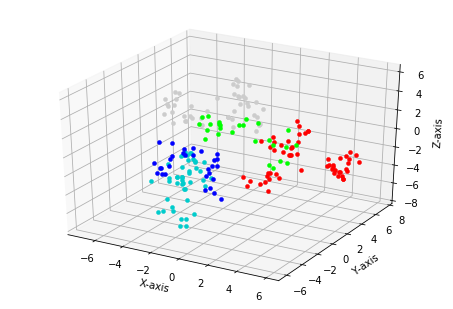

In [121]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt


# グラフ作成
fig = pyplot.figure()
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
display_df[display_df.label == 0].x.values
# 表示範囲の設定
# ax.set_xlim(4, 8)
# ax.set_ylim(2, 5)
# ax.set_zlim(1, 8)

for l, color in zip(range(0,5), ["#cccccc", "#00cccc", "#ff0000", "#00ff00" ,"#0000ff"]):
    ax.plot(display_df[display_df.label == l].x.values, display_df[display_df.label == l].y.values, display_df[display_df.label == l].z.values, "o", color=color, ms=4, mew=0.5)


# グラフ描画
# ax.plot(d1, d2, d3, "o", color="#ff0000", ms=4, mew=0.5)

pyplot.show()

In [80]:
display_df['label_ut'] = (display_df.label == 0)
display_df['label_ky'] = (display_df.label == 1)
display_df['label_wa'] = (display_df.label == 2)
display_df['label_ko'] = (display_df.label == 3)
display_df['label_me'] = (display_df.label == 4)
submit_df = pd.merge(display_df, node_df[['id', 'query']])
submit_df

,id,x,y,z,label,shortest_step,label_ut,label_ky,label_wa,label_ko,label_me,query
0,0,-3.000000,3.000000,3.000000,0,0,True,False,False,False,False,東京大学
1,102,-4.098553,4.517024,0.656537,0,1,True,False,False,False,False,消費
2,37,-2.195149,4.017978,0.295202,0,1,True,False,False,False,False,キャンパス
3,71,-4.124945,0.230210,2.749474,0,1,True,False,False,False,False,ライフ
4,23,-2.413240,4.555757,0.502935,0,1,True,False,False,False,False,生活協同組合
5,34,-1.983522,4.958066,1.882605,0,2,True,False,False,False,False,方針
6,164,-5.044975,5.677151,0.748134,0,2,True,False,False,False,False,受付
7,69,-1.387771,5.331414,-0.269573,0,2,True,False,False,False,False,保護
8,38,-3.269031,2.975393,0.394162,0,2,True,False,False,False,False,オープン
9,136,-2.743223,4.922473,-0.913621,0,2,True,False,False,False,False,ポータルサイト


In [81]:
# nodes.csv position.csv を出力
submit_df[['id', 'x', 'y', 'z']].to_csv('position.csv')
submit_df[['id', 'query', 'label_ut', 'label_ky', 'label_wa', 'label_ko', 'label_me']].to_csv('nodes.csv')

# リンク

In [136]:
# fromが属するlabelとtoが属するlabelが異なるものをlinkとして繋げれば良い
tmp_df = pd.merge(link_df, node_df[['id', 'label']], left_on='from_id', right_on='id').rename(columns={'label':'from_label'}).drop('id', axis=1)
dif_univ_link_df = pd.merge(tmp_df, node_df[['id', 'label']], left_on='to_id', right_on='id').rename(columns={'label':'to_label'}).drop('id', axis=1)
dif_univ_link_df

,from,to,value,from_id,to_id,from_label,to_label
0,慶應義塾大学,研究,0.025952,3,198,3,1
1,京都大学,研究,0.025132,1,198,1,1
2,早稲田大学,研究,0.027716,2,198,2,1
3,東京大学,研究,0.032507,0,198,0,1
4,月,研究,0.023916,131,198,3,1
5,月,研究,0.023916,131,198,3,1
6,月,研究,0.023916,131,198,3,1
7,月,研究,0.023916,131,198,3,1
8,科学,研究,0.064525,169,198,1,1
9,科学,研究,0.064525,169,198,1,1


In [137]:
sub_dif_univ_link_df = dif_univ_link_df[dif_univ_link_df.from_label != dif_univ_link_df.to_label][['from','to','value','from_id','to_id']].drop_duplicates().reset_index(drop=True)
sub_dif_univ_link_df

,from,to,value,from_id,to_id
0,慶應義塾大学,研究,0.025952,3,198
1,早稲田大学,研究,0.027716,2,198
2,東京大学,研究,0.032507,0,198
3,月,研究,0.023916,131,198
4,会,研究,0.070546,43,198
5,学会,研究,0.048892,132,198
6,センター,研究,0.024388,84,198
7,情報,学部,0.045043,147,48
8,研究,月,0.023916,198,131
9,発信,月,0.019162,154,131


In [135]:
sub_dif_univ_link_df.to_csv('links.csv')

## 以下不要

In [212]:
ut_node_df.shortest_step.unique()

array([ 0,  2,  3,  1, 99])

In [210]:
ut1_nodes = ut_node_df[ut_node_df.shortest_step == 1]['index'].values
ut1_nodes[0:5]

array([ 47,  86, 124, 174])

In [85]:
from numpy.random import *
start_positions = [np.array([r[0], uniform(0, np.pi, 1)[0], uniform(0, np.pi, 1)[0]]) for _ in range(len(ut1_nodes))]
start_positions

[array([2.        , 0.91372616, 0.51494615]),
 array([2.        , 2.37748521, 0.31069466]),
 array([2.        , 2.72729032, 2.97037884]),
 array([2.        , 0.06283199, 3.06617545])]

In [204]:
from numpy.random import *
start_positions = [np.array([r[0], uniform(0, np.pi, 1)[0], uniform(0, np.pi, 1)[0]]) for _ in range(len(ut1_nodes))]

In [205]:
import copy
positions = copy.deepcopy(start_positions)
for c in range(100): 
    Fs = [0]* len(positions)
    for i in range(len(positions)):
        F = np.array([0,0,0])
        for j, position in enumerate(positions):
            if i != j:
                F = F + (positions[i] - position  - (positions[i] - position) / (positions[i] - position).sum())
        Fs[i] = F / (len(positions) - 1)
    for i in range(len(positions)):
        for j in range(len(Fs[i])):
            while abs(Fs[i][j]) > np.pi:
                if Fs[i][j] > 0:
                    Fs[i][j] = Fs[i][j] - np.pi
                else:
                    Fs[i][j] = Fs[i][j] + np.pi
        positions[i] = positions[i] + Fs[i] / np.pi
    if c % 100 == 0:
        print(np.sum(np.absolute(np.array(list(map(r2xyz, Fs))))))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [206]:
positions

[array([  2.        , -37.12256008,  51.24022178]),
 array([  2.        , -39.3012347 , -49.26466937]),
 array([ 2.        , 50.85968568, 49.15186897]),
 array([  2.        , -36.97174579, -46.42917494])]

In [122]:
import copy
positions = copy.deepcopy(start_positions)
for c in range(100): 
    xyz_Fs = [0]* len(positions)
    xyz_positions = list(map(r2xyz, positions))
    for i in range(len(xyz_positions)):
        xyz_F = np.array([0,0,0])
        for j, xyz_position in enumerate(xyz_positions):
            if i != j:
                xyz_F = xyz_F + xyz_positions[i] - xyz_position
        xyz_Fs[i] = xyz_F / (len(positions) - 1)
    for i in range(len(positions)):
        F = xyz2r(xyz_Fs[i])
        positions[i] = positions[i] + np.array([0, F[1], F[2]])
    if c % 10 == 0:
        print(np.sum(np.absolute(np.array(xyz_Fs))))

14.88407120426629
15.638798093163578
14.333989950069537
15.146441348787073
12.603028812079522
13.277180044435761
12.565119986270746
15.486227761066399
12.298536774107818
13.816529744629948


In [14]:
from_ids =  np.array(link_df.from_id)
to_ids = np.array(link_df.to_id)
distances = np.array(node_df.shortest_step)
from numpy.random import *
start_positions = uniform(-2,2, (len(node_ids), 3))
start_positions[0] = np.array([-1,1,1])
start_positions[1] = np.array([-1,-1,-1])
start_positions[2] = np.array([1,1,-1])
start_positions[3] = np.array([1,-1,1])
start_positions[4] = np.array([-1,1,-1])

In [15]:
import copy
positions = copy.deepcopy(start_positions)
for i in range(500): 
    Fs = [0]* len(node_ids)
    for node_id in node_ids:
        if node_id not in [0, 1, 2, 3, 4]:
            P = positions[node_id]
            F = np.array([0, 0, 0])
            linked_node_ids = to_ids[np.where(from_ids == node_id)]
            for node_i_id in linked_node_ids:
                D_i = float(distances[node_i_id] + 1)
                P_i = positions[node_i_id]
                x_i = (P_i - P) - ((P_i - P) / np.linalg.norm(P_i - P)) # バネの伸びベクトル(バネのもとの長さは1)
                F_i = x_i * (1/D_i)  # Nに働く力ベクトルを算出(バネ定数はD_iの逆数)
                F = F + F_i
            Fs[node_id] = F * D_i * 0.001
    for node_id in node_ids:
        positions[node_id] = positions[node_id] + Fs[node_id]
    if i % 10 == 0:
        print(np.sum(np.absolute(np.array(Fs[5:]))))

1.7620500506984893
1.0680517767601132
0.8462521172021142
0.7262024956024857
0.6445526374785355
0.5835756479596732
0.5354052999324581
0.49592783194116374
0.4630324626032821
0.4353502635296573
0.4113384457400659
0.39033787970235656
0.3715139006296242
0.3541437928693111
0.33825280599499985
0.32329517566470933
0.309151408545218
0.2957700143697295
0.2831029222966808
0.27109806450839813
0.25974616040979764
0.24910598785116123
0.23894592948543902
0.22928707427806588
0.22013320469822162
0.211408245100962
0.20314261435854622
0.1954101257085576
0.18820339800348937
0.18132342187645994
0.174776586084944
0.16851257908233633
0.16268639554377462
0.1574420940908895
0.15249696960563372
0.14782818173351792
0.1434227145841624
0.13932339629673074
0.13546614071585467
0.13186932866664125
0.12835367490432165
0.12480656421202056
0.12126676062880197
0.11789391943441735
0.11460286211937323
0.11135414476296127
0.10818877746055972
0.10512198302773104
0.10232895437737519
0.09958615354539944


In [16]:
from numpy.random import *
positions = []
for nearest_univ_node in nearest_univ_nodes:
    if len(nearest_univ_node) == 1:
        if nearest_univ_node[0] == 0:
            p = np.array([uniform(-3, -2, 1)[0], uniform(2, 3, 1)[0], uniform(2, 3, 1)[0]])
        elif nearest_univ_node[0] == 1:
            p = uniform(-3, -2, 3)
        elif nearest_univ_node[0] == 2:
            p = np.array([uniform(2, 3, 1)[0], uniform(-3, -2, 1)[0], uniform(2, 3, 1)[0]])
        elif nearest_univ_node[0] == 3:
            p = np.array([uniform(-3, -2, 1)[0], uniform(2, 3, 1)[0], uniform(-3, -2, 1)[0]])
        elif nearest_univ_node[0] == 4:
            p = np.array([uniform(2, 3, 1)[0], uniform(2, 3, 1)[0], uniform(-3, -2, 1)[0]])
    elif len(nearest_univ_node) == 2:
        zeros = np.where(univs_positions[nearest_univ_node[0]] + univs_positions[nearest_univ_node[1]] == 0)[0]
        p = [0, 0, 0]
        for i in range(3):
            if i in zeros:
                p[i] = uniform(-1, 1, 1)[0]
            else:
                univ_p = univs_positions[nearest_univ_node[0]][i]
                if univ_p == -1:
                    p[i] = uniform(-1.6, -1.1, 1)[0]
                else:
                    p[i] = uniform(1.1, 1.6, 1)[0]
        p = np.array(p)
    else:
        p = uniform(-1, 1, 3)
    positions.append(p)
not_univ_nodes_p = np.array(positions)

NameError: name 'nearest_univ_nodes' is not defined